# Create lithogenic and biogenic particle fields for Pb scavenging

BLING ends in April, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import xarray as xr
import cmocean
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator

%matplotlib inline

#### Parameters / settings:

In [2]:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

#### Load files

In [3]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

In [4]:
# BLING:
folder_EPM101 = '/data/brogalla/ANHA4/BLING-EPM101/'
dset          = xr.open_dataset(f'/ocean/brogalla/GEOTRACES/BLING-EPM101/ANHA4-EPM101_y2002m08d13_gridB.nc')
ANHA4_lons    = dset['nav_lon'].values
ANHA4_lats    = dset['nav_lat'].values
ANHA4_depths  = dset['deptht'].values

In [5]:
# Mn for surface particle field:
dset_ANHA12 = xr.open_dataset('/data/brogalla/run_storage/Mn-extended-domain-202210/oMn_y2002m01.nc')
ANHA12_lons = mesh_lon[imin:imax,jmin:jmax]
ANHA12_lats = mesh_lat[imin:imax,jmin:jmax]

#### Functions:

In [6]:
def find_max_bio(year, month):
    # BLING:
    file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
    dset_bio    = xr.open_dataset(f'{file_EPM101}')
#     biomass     = dset_bio['biomass_p'][:,:,:].values
    biomass     = dset_bio['jp_pop'][:,:,:].values
    
    # interpolate from ANHA4 to ANHA12 grid:
    ANHA12_biomass = np.empty((50,isize,jsize))
    for depth in range(0,50):
        interpolator   = LinearNDInterpolator(tri, biomass[depth,:,:].flatten())    
    
        ANHA12_biomass[depth,:,:] = interpolator(np.array([ANHA12_lons.flatten(), ANHA12_lats.flatten()]).transpose()).reshape(ANHA12_lons.shape)

    ANHA12_biomass[ANHA12_biomass < 0] = 0
    
    max_bio = np.amax(ANHA12_biomass)

    return max_bio

def find_max_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    dset_ANHA12 = xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc')
    ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 
    
    max_litho = np.amax(ANHA12_Mn)
    
    return max_litho

In [7]:
def save_file(folder, litho_array, bio_array, year, month):    
    file_write = xr.Dataset(
        {'lithogenic' : (("deptht","y","x"), litho_array),
         'biogenic' : (("deptht","y","x"), bio_array)}, 
        coords = {
            "time_counter": np.zeros(1),
            "deptht": depths,
            "y": np.zeros(mesh_lat.shape[0]),
            "x": np.zeros(mesh_lon.shape[1])},
    )
    file_write.to_netcdf(f'{folder}Pb_scavenging_y{year}m{month:02}.nc', \
                         unlimited_dims='time_counter')
    
    return

In [8]:
# interpolate from ANHA4 to ANHA12 grid:
tri = Delaunay(np.array([ANHA4_lons.flatten(), ANHA4_lats.flatten()]).transpose())  # Compute the triangulation

def load_bio(year, month):
    # BLING:
    file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
    dset_bio    = xr.open_dataset(f'{file_EPM101}')
#     biomass     = dset_bio['biomass_p'][:,:,:].values
    biomass     = dset_bio['jp_pop'][:,:,:].values
    
    # interpolate from ANHA4 to ANHA12 grid:
    ANHA12_biomass = np.empty((50,isize,jsize))
    for depth in range(0,50):
        interpolator   = LinearNDInterpolator(tri, biomass[depth,:,:].flatten())    
    
        ANHA12_biomass[depth,:,:] = interpolator(np.array([ANHA12_lons.flatten(), ANHA12_lats.flatten()]).transpose()).reshape(ANHA12_lons.shape)

    ANHA12_biomass[ANHA12_biomass < 0] = 0
    
    return ANHA12_biomass

def load_litho(year, month):
    # Mn for surface particle field:
    folder_Mn   = f'/data/brogalla/run_storage/Mn-extended-domain-202210/'
    dset_ANHA12 = xr.open_dataset(f'{folder_Mn}oMn_y{year}m{month:02}.nc')
    ANHA12_Mn   = dset_ANHA12['oxidismn'][:,:,:].values 
    
    return ANHA12_Mn

In [32]:
def create_particle_fields(year, month, max_bio=np.nan, max_litho=np.nan, save=False, beta=np.nan):
    ANHA12_biomass = load_bio(year, month)
    ANHA12_litho   = load_litho(year, month)

    # particles: normalize by maximum value within domain over the course of the full time series
    normalized_biogenic   = ANHA12_biomass / max_bio 
    normalized_lithogenic = ANHA12_litho / max_litho 

    # initialize arrays with some small value, then fill with normalized particle fields:
    lithogenic_particles = np.ones(mesh_bathy.shape)*0.001
    biogenic_particles   = np.ones(mesh_bathy.shape)*0.001
    lithogenic_particles[:,imin:imax,jmin:jmax] = normalized_lithogenic
    biogenic_particles[:,imin:imax,jmin:jmax]   = normalized_biogenic
    
    if save:
        if np.isnan(beta):
            print('need to define beta')
        else:
            folder ='/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/'
            betas  = [0.01, 0.05, 0,15, 0.25, 0.5, 0.75, 0.95] #[0.00, 0.01, 0.02, 0.03, 0.05, 0.15, 0.25, 0.50, 0.75, 0.95]
            save_file(f'{folder}particle001/', lithogenic_particles*betas[0], biogenic_particles*(1-betas[0]), year, month)
            save_file(f'{folder}particle005/', lithogenic_particles*betas[1], biogenic_particles*(1-betas[1]), year, month)
            save_file(f'{folder}particle015/', lithogenic_particles*betas[2], biogenic_particles*(1-betas[2]), year, month)
            save_file(f'{folder}particle025/', lithogenic_particles*betas[3], biogenic_particles*(1-betas[3]), year, month)
            save_file(f'{folder}particle050/', lithogenic_particles*betas[4], biogenic_particles*(1-betas[4]), year, month)
            save_file(f'{folder}particle075/', lithogenic_particles*betas[5], biogenic_particles*(1-betas[5]), year, month)
            save_file(f'{folder}particle095/', lithogenic_particles*betas[6], biogenic_particles*(1-betas[6]), year, month)
    
    return ANHA12_litho, ANHA12_biomass #lithogenic_particles, biogenic_particles

#### Calculations

In [10]:
# Maximum value in file: 
n=0
max_bio_list   = np.empty((12*19)); max_bio_list[:]   = np.nan;
max_litho_list = np.empty((12*19)); max_litho_list[:] = np.nan;
for year in range(2002, 2021):
    print(year)
    for month in range(1,13):
        try:
            max_bio = find_max_bio(year, month)
        except:
            max_bio = np.nan
            
        try:
            max_litho = find_max_litho(year, month)
        except:
            max_litho = np.nan
            
        max_bio_list[n]   = max_bio            
        max_litho_list[n] = max_litho
        
        n+=1

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [11]:
print(np.nanmax(max_bio_list), np.nanmax(max_litho_list))

4.712349976898622e-08 1.8331377305003116e-07


Create particle fields and save:

In [33]:
for month in range(1,2):
    print(month)
    litho, bio = create_particle_fields(2016, month, max_bio=4.71235e-8, max_litho=1.83314e-7, save=False, beta=0.00)

1


#### Extra: compare ANHA4 original field and interpolated field:
Look basically the same (except for ANHA4 grid artefact thingy

In [34]:
year=2016; month=1;
file_EPM101 = f'/data/brogalla/ANHA4/BLING-EPM101/ANHA4-EPM101_y{year}m{month:02}.nc'
dset_bio    = xr.open_dataset(f'{file_EPM101}')
bio_ANHA4   = dset_bio['jp_pop'][:,:,:].values

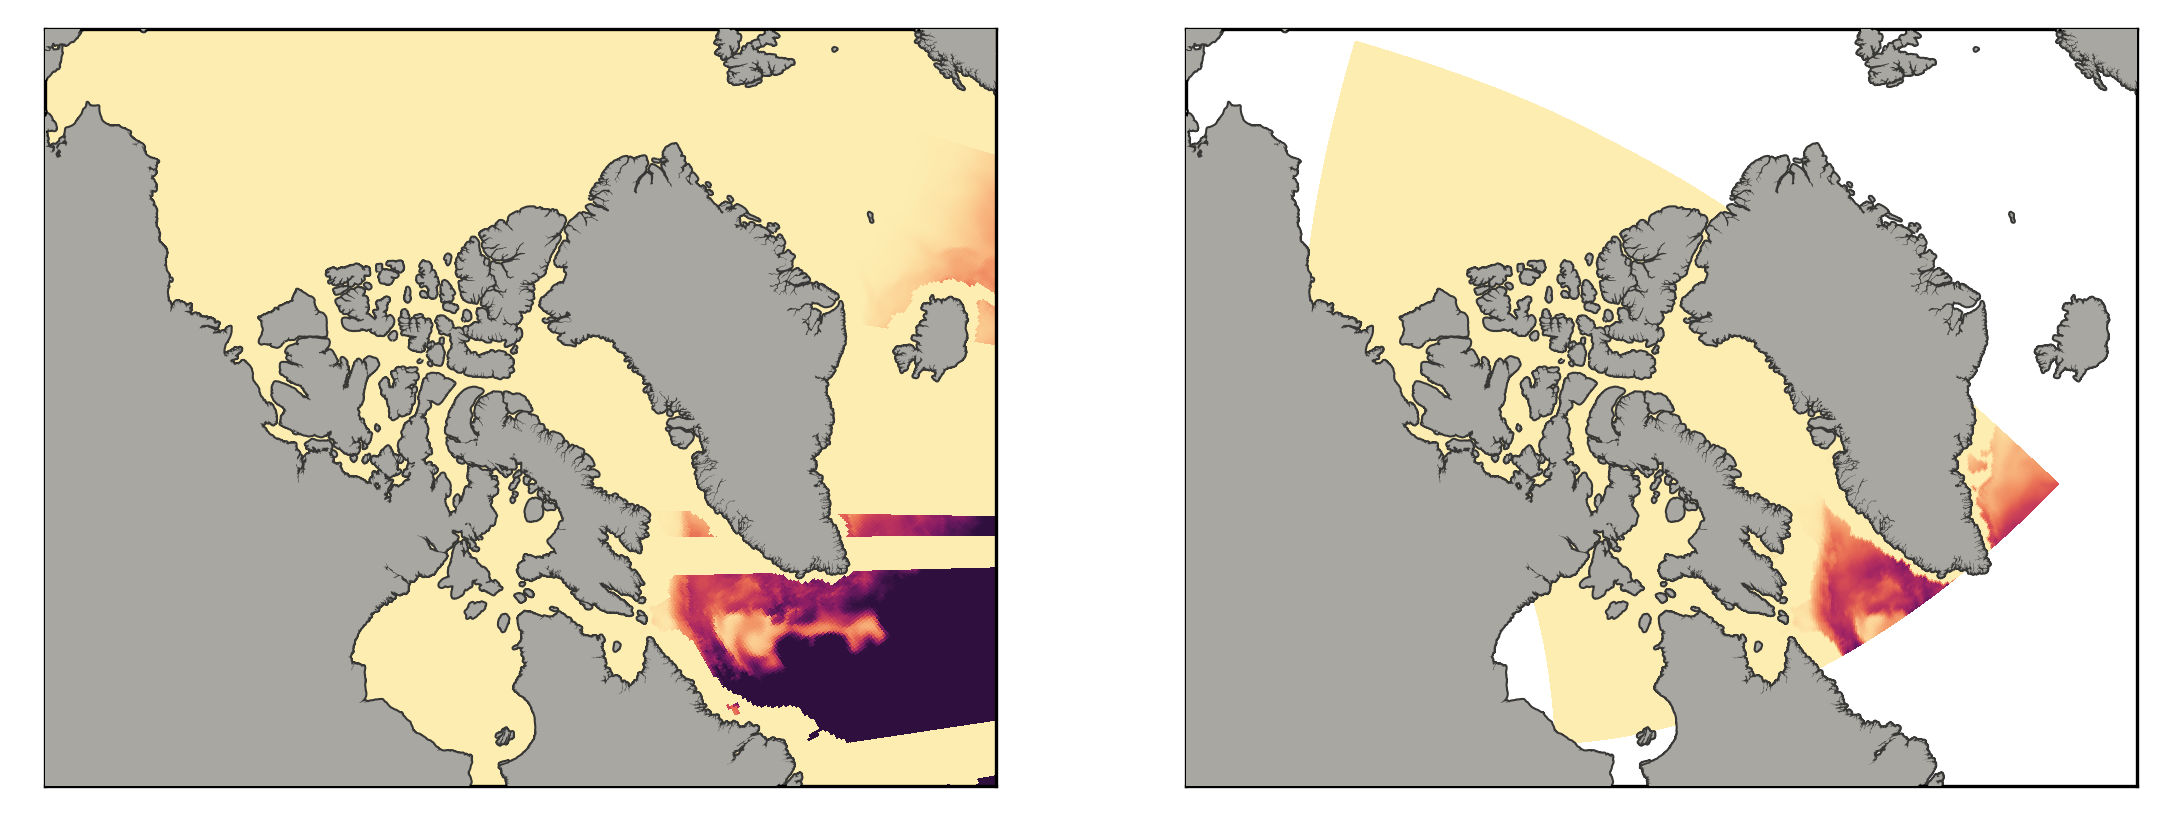

In [48]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=300)

proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color='#373736', linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[1])
proj2.drawcoastlines(color='#373736', linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

xANHA4 , yANHA4  = proj1(ANHA4_lons , ANHA4_lats)
xANHA12, yANHA12 = proj2(ANHA12_lons, ANHA12_lats)

CB1 = proj1.pcolormesh(xANHA4, yANHA4, bio_ANHA4[30,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-10)
CB2 = proj2.pcolormesh(xANHA12, yANHA12, bio[30,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=1e-10)

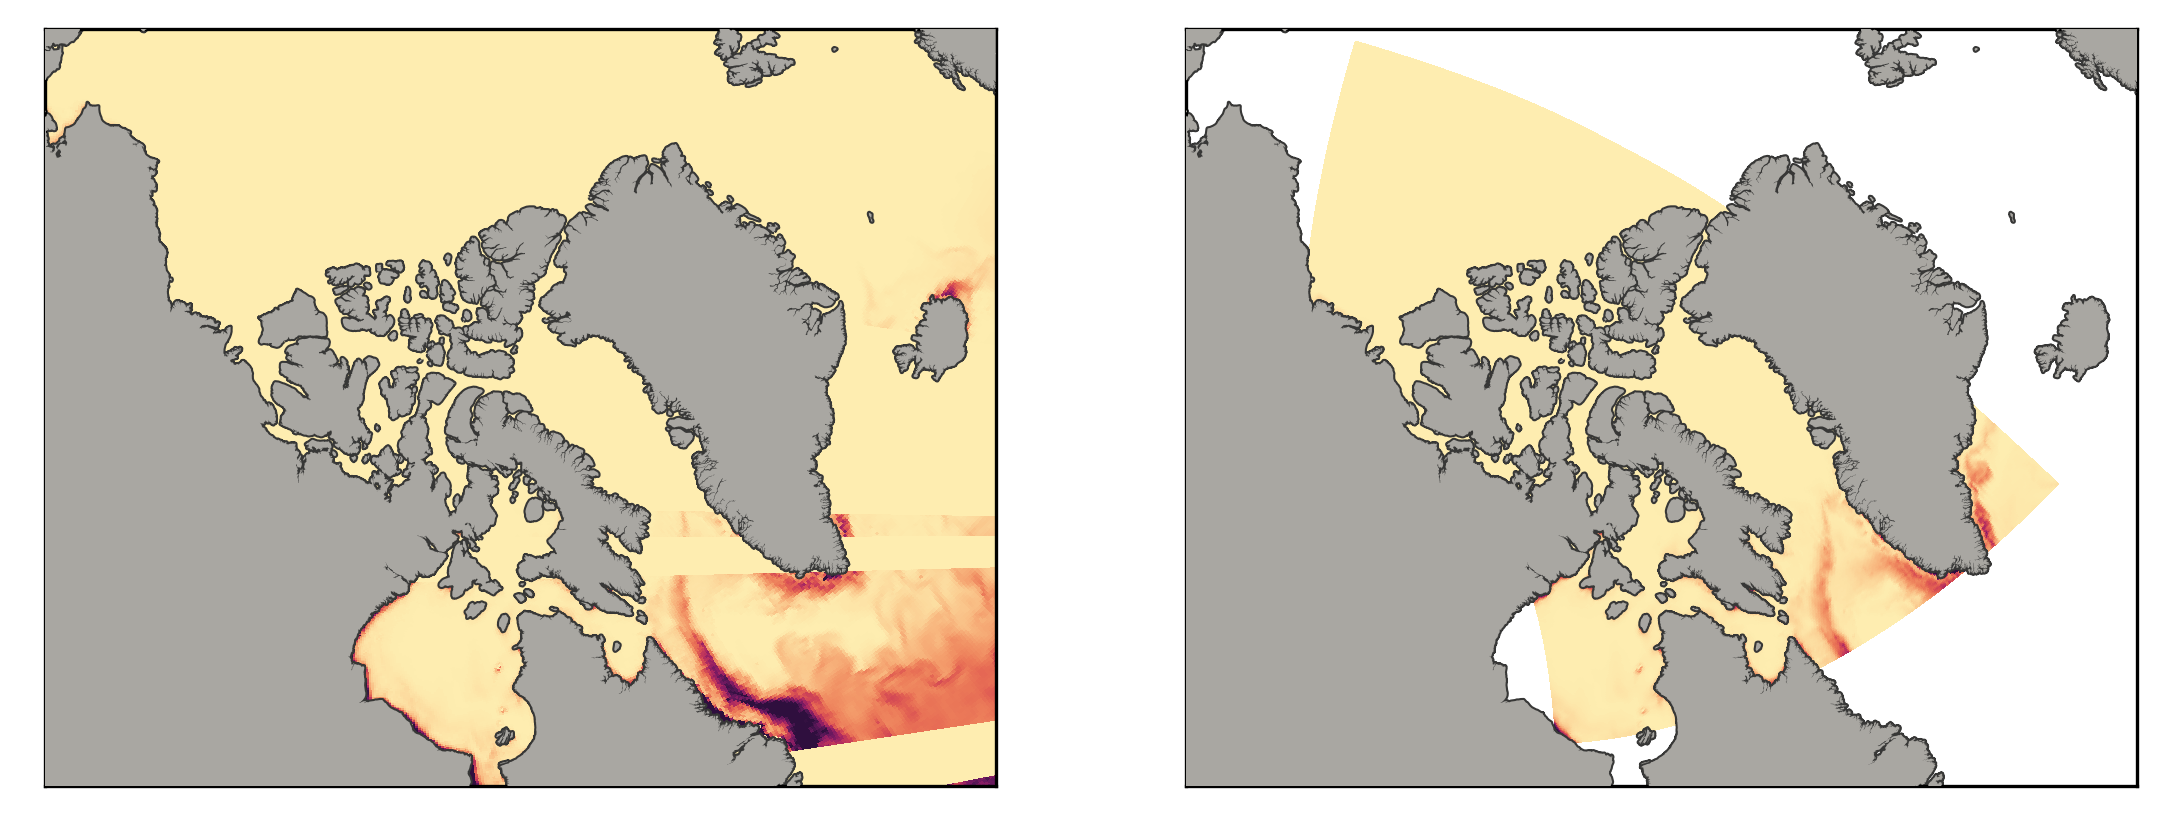

In [47]:
fig, ax = plt.subplots(1,2,figsize=(9,4),dpi=300)

proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color='#373736', linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

proj2=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -78, resolution='i', width=5.4e6, height=4.3e6, ax=ax[1])
proj2.drawcoastlines(color='#373736', linewidth=1.0);
proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=5);

xANHA4 , yANHA4  = proj1(ANHA4_lons , ANHA4_lats)
xANHA12, yANHA12 = proj2(ANHA12_lons, ANHA12_lats)

CB1 = proj1.pcolormesh(xANHA4, yANHA4, bio_ANHA4[0,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=5e-11)
CB2 = proj2.pcolormesh(xANHA12, yANHA12, bio[0,:,:], cmap=cmocean.cm.matter, vmin=0, vmax=5e-11)